---
## Introduction
From Kaggle open resource, we had **training** dataset, **public test** dataset (which is then used as validation dataset for our project), and further a **private test** dataset (same size with public test dataset and will be used as data for evaluating the prediction performance).

Image set of 35,887 examples, with training-set : **80%**, validation-set : **10%** and test-set : **10%**.

---

## Import libraries

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import os

## Dataset Overview

In [2]:
data = pd.read_csv('fer2013.csv')
#check data shape
data.shape
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [4]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


----------------------------------------------------------------------------------
## Pre-processing data
1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape to 48x48 and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to \[0,0,0,1,0,0,0]

In [5]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {} \nvalidation shape: {} \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3) 
validation shape: (3589, 3) 
test shape: (3589, 3)


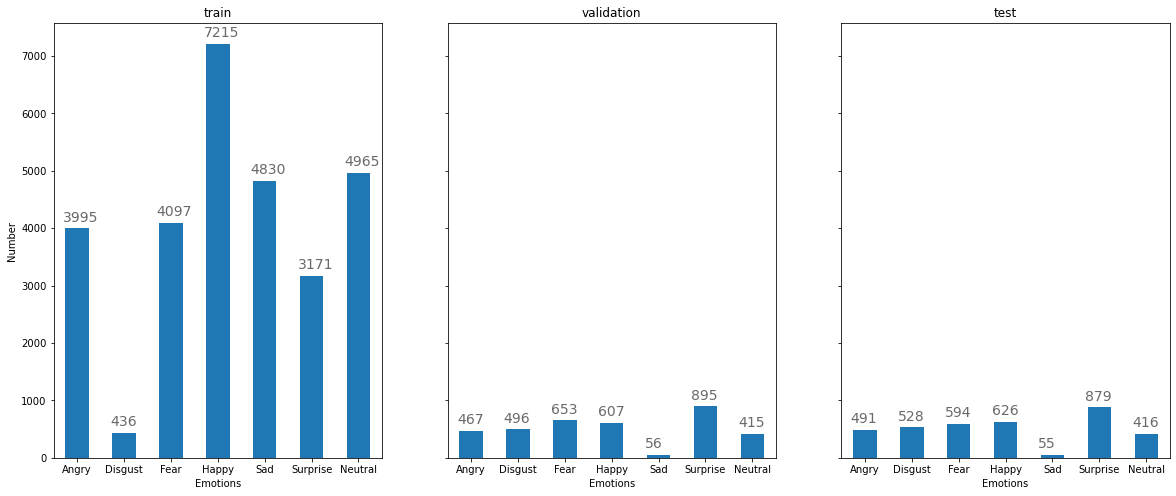

In [6]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

Notice that the later two subplots share the same y-axis with the first subplot. 

The size of **train**, **validation**, **test** are **80%**, **10%** and **10%**, respectively. 

The exact number of each class of these datasets are written on top of their x-axis bar. 

In [7]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

num_classes = 7
height,width = 48, 48

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


----------------------------------------------------------------------------------
## Building CNN Model

### CNN Architecture:  
* Conv -> BN -> Activation -> MaxPooling -> Dropout
* Conv -> BN -> Activation -> MaxPooling -> Dropout
* Conv -> BN -> Activation -> MaxPooling -> Dropout
* Conv -> BN -> Activation -> MaxPooling -> Dropout
* Flatten
* Dense -> BN -> Activation -> Dropout
* Dense -> BN -> Activation -> Dropout
* Dense (softmax)
* Output layer

In [8]:
# Initialising the CNN
model = Sequential()

# 1st - Convolution Layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer : 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer : 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

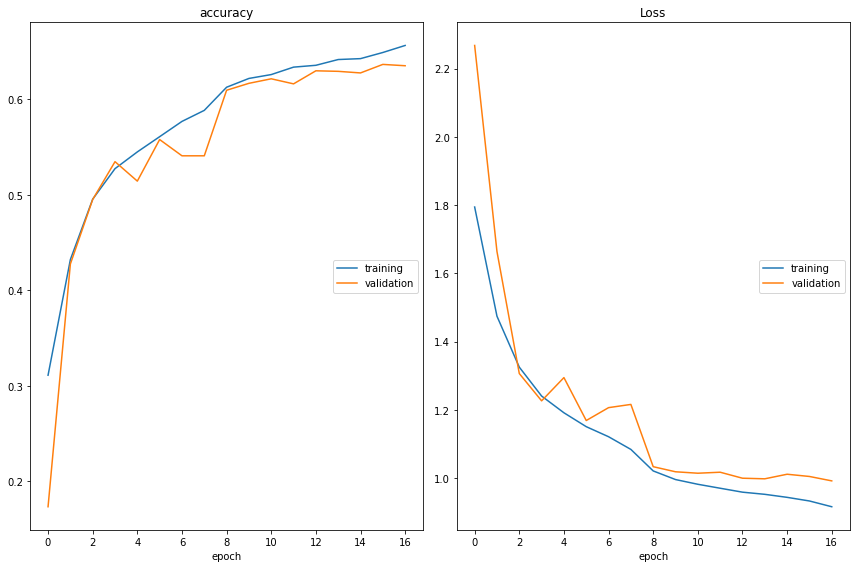

accuracy
	training         	 (min:    0.311, max:    0.657, cur:    0.657)
	validation       	 (min:    0.174, max:    0.637, cur:    0.635)
Loss
	training         	 (min:    0.916, max:    1.794, cur:    0.916)
	validation       	 (min:    0.992, max:    2.268, cur:    0.992)

Epoch 00017: saving model to model_weights.h5
448/448 [==============================] - 1150s 3s/step - loss: 0.9164 - accuracy: 0.6566 - val_loss: 0.9921 - val_accuracy: 0.6353


In [9]:
img_size = 48
batch_size = 64


datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow(train_X, train_Y,
                                                    batch_size=batch_size,
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow(val_X, val_Y,
                                                    batch_size=batch_size)

epochs = 17
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reducing Learning Rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

# Training the Model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=[PlotLossesKerasTF(), reduce_lr, checkpoint]
)

In [10]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Evaluate Test Performance

In [11]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6484


## Analysis using Confusion Matrix

Confusion Matrix is applied and plotted to find out which emotion usually get confused with each other.

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

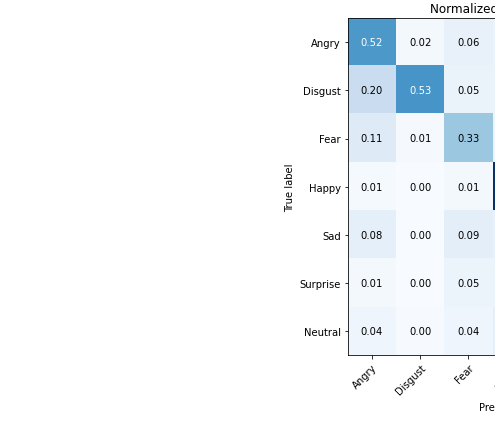

In [13]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

## Analysis using Precision, Recall and F1-Score


Precision : Percent of positive predictions made which were correct

    precision = True positives / (True positives + False positives)

Recall : Percent of Actual positive values were correctly classified by your classifier

    recall = True positives / (True positives + False negatives)

F1-Score : It is harmonic mean of precision and recall.

    f1-score = (2 * precision * recall) / (precision + recall)

In [14]:
print(classification_report(test_true, test_pred, target_names=emotion_labels))

              precision    recall  f1-score   support

       Angry       0.63      0.52      0.57       491
     Disgust       0.58      0.53      0.55        55
        Fear       0.55      0.33      0.41       528
       Happy       0.83      0.87      0.85       879
         Sad       0.48      0.60      0.54       594
    Surprise       0.73      0.81      0.77       416
     Neutral       0.60      0.65      0.62       626

    accuracy                           0.65      3589
   macro avg       0.63      0.62      0.62      3589
weighted avg       0.65      0.65      0.64      3589

